## 18/02/2019

- Performance of classification model trained on a feature vector containing features from signals in each electrode.
- Plot of feature vectors, and classification errors, using PCA.

In [2]:
# Import necessary modules. Set settings. Import data.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from epdata_tools import epdata_main, get_ep_features, get_ep_feature_dict
from IPython.display import HTML

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm, naive_bayes, neighbors, gaussian_process
from sklearn.gaussian_process.kernels import RBF
import xgboost

from IPython.display import display, clear_output
import pdb

plt.style.use('default')

X_compact = pd.read_pickle('/Users/matthewashman/github/MasterProject2018/Data/X_af_compact.pkl')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
X_compact.head()

,CS1-2,CS3-4,CS5-6,CS7-8,Coupling Interval,Label,Patient,S1/S2,Type
0,"[-903.0, -873.0, -935.0, -941.0, -910.0, -845....","[298.0, 292.0, 303.0, 311.0, 299.0, 395.0, 451...","[1776.0, 2220.0, 1790.0, -4058.0, -15027.0, -2...","[6283.0, 6464.0, 5952.0, 4507.0, 3694.0, 2873....",340,NaN,1,S1,af
1,"[-931.0, -896.0, -896.0, -906.0, -858.0, -839....","[339.0, 328.0, 348.0, 328.0, 299.0, 361.0, 349...","[1678.0, 2049.0, 2080.0, -1681.0, -11648.0, -1...","[6161.0, 6208.0, 5897.0, 4703.0, 3732.0, 2980....",340,NaN,1,S1,af
2,"[-931.0, -896.0, -896.0, -906.0, -858.0, -839....","[339.0, 328.0, 348.0, 328.0, 299.0, 361.0, 349...","[1678.0, 2049.0, 2080.0, -1681.0, -11648.0, -1...","[6161.0, 6208.0, 5897.0, 4703.0, 3732.0, 2980....",340,NaN,1,S1,af
3,"[-985.0, -925.0, -943.0, -919.0, -935.0, -877....","[255.0, 287.0, 321.0, 335.0, 396.0, 400.0, 491...","[2053.0, 2296.0, -448.0, -11020.0, -19196.0, -...","[5944.0, 5725.0, 4579.0, 3615.0, 2952.0, 1393....",330,NaN,1,S1,af
4,"[-1025.0, -913.0, -885.0, -903.0, -864.0, -947...","[262.0, 285.0, 336.0, 349.0, 342.0, 490.0, 506...","[1726.0, 2111.0, 2289.0, -736.0, -11322.0, -19...","[6270.0, 6584.0, 6191.0, 4876.0, 3749.0, 2986....",330,NaN,1,S1,af


In [4]:
# Create a list of ditionaries using get_ep_feature_dict(). Each dictionary contains all the features for each 
# of the four segments in CS1-2, CS3-4 and CS5-6.
X_feature_dicts = []
for i, row in X_compact[X_compact['S1/S2']=='S2'].iterrows():
    clear_output(wait=True)
    display('Extracting Features: ' + str(round(100*i/X_compact[(X_compact['S1/S2']=='S2')].index[-1],3)) + '%')
    
    dicts = []
    ref_dicts = []
    ref = X_compact[(X_compact['S1/S2']=='S1') & (X_compact['Patient']==row['Patient'])].sort_values(by=['Coupling Interval'], ascending=False).iloc[0]
    dicts.append(get_ep_feature_dict(row['CS1-2'], 'CS1-2'))
    ref_dicts.append(get_ep_feature_dict(ref['CS1-2'], 'CS1-2'))
    dicts.append(get_ep_feature_dict(row['CS3-4'], 'CS3-4'))
    ref_dicts.append(get_ep_feature_dict(ref['CS3-4'], 'CS3-4'))
    dicts.append(get_ep_feature_dict(row['CS5-6'], 'CS5-6'))
    ref_dicts.append(get_ep_feature_dict(ref['CS5-6'], 'CS5-6'))
    
    feature_dict = {}
    for d, d_ref in zip(dicts, ref_dicts):
        for k, v in d.items():
            feature_dict[k] = v - d_ref.get(k)
        
    feature_dict['Type'] = row['Type']
    feature_dict['Patient'] = row['Patient']
    feature_dict['Coupling Interval'] = row['Coupling Interval']
    feature_dict['Label'] = row['Label'] 
#     for d in dicts:
#         for k, v in d.items():
#             feature_dict[k] = v 
            
    X_feature_dicts.append(feature_dict)
    
X_features = pd.DataFrame(X_feature_dicts)

'Extracting Features: 100.0%'

In [72]:
X_features.columns
len(X_features['Label'].values) - np.sum(X_features['Label'].values)

86.0

In [63]:
# Perform training test split on patients. i.e., 3 patients in the test set and 7 in training.
patient_nums = list(range(1,11))
patient_nums.remove(7) # Forget patient 7 for now
random.shuffle(patient_nums)

test_patients = patient_nums[-3:]
training_patients = patient_nums[:7]
training_patients = [str(x) for x in training_patients]
test_patients = [str(x) for x in test_patients]
print(training_patients)
print(test_patients)

['6', '1', '5', '4', '10', '9', '2']
['2', '3', '8']


In [64]:
X_training = X_features[X_features['Patient'].isin(training_patients)].drop(['Label', 'Patient', 'Type', 'Coupling Interval'], axis=1)
y_training = X_features[X_features['Patient'].isin(training_patients)]['Label']
info_training = X_features[X_features['Patient'].isin(training_patients)][['Label', 'Patient', 'Type', 'Coupling Interval']]


X_test = X_features[X_features['Patient'].isin(test_patients)].drop(['Label', 'Patient', 'Type', 'Coupling Interval'], axis=1)
y_test = X_features[X_features['Patient'].isin(test_patients)]['Label']
info_test = X_features[X_features['Patient'].isin(test_patients)][['Label', 'Patient', 'Type', 'Coupling Interval']]

In [65]:
X_test.shape[0]

47

In [66]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [67]:
# Get cross validation scores on training data, following by test score.
import warnings
warnings.filterwarnings('ignore')

models = (svm.SVC(), naive_bayes.GaussianNB(), neighbors.KNeighborsClassifier(), 
          gaussian_process.GaussianProcessClassifier(kernel=1.0*RBF(1)), xgboost.XGBClassifier())
model_names = ('SVM', 'Naive Bayes', 'KNN', 'GP', 'XGBoost')
print('Cross validation scores on combined data:')
for clf, model_name in zip(models, model_names):
    print(model_name)
    print(cross_val_score(clf, X_training.values, y_training.values, cv=3))
    
for clf, model_name in zip(models, model_names):
    clf.fit(X_training.values, y_training.values)
    print(model_name)
    print(clf.score(X_test.values, y_test.values))
    predictions = clf.predict(X_test.values)
    cm = confusion_matrix(y_test, predictions)
    print_cm(cm, ['Not Fractionated','Fractionated'])
    info_test[model_name + ' Predictions'] = predictions

Cross validation scores on combined data:
SVM
[0.72413793 0.72413793 0.75      ]
Naive Bayes
[0.96551724 0.79310345 0.89285714]
KNN
[0.72413793 0.65517241 0.71428571]
GP
[0.72413793 0.72413793 0.75      ]
XGBoost
[0.86206897 0.68965517 0.89285714]
SVM
0.8297872340425532
           t/p       Not Fractionated     Fractionated 
    Not Fractionated             39.0              0.0 
        Fractionated              8.0              0.0 
Naive Bayes
0.8936170212765957
           t/p       Not Fractionated     Fractionated 
    Not Fractionated             37.0              2.0 
        Fractionated              3.0              5.0 
KNN
0.7446808510638298
           t/p       Not Fractionated     Fractionated 
    Not Fractionated             35.0              4.0 
        Fractionated              8.0              0.0 
GP
0.8297872340425532
           t/p       Not Fractionated     Fractionated 
    Not Fractionated             39.0              0.0 
        Fractionated              8.0

In [11]:
feature_names = X_test.columns
# Separating out the features
x = X_test.loc[:, feature_names].values

# Separating out the labels
labels = info_test.loc[:,['Label']].values


# Seperating out the predicitons
predictions = info_test.loc[:, ['XGBoost Predictions']]

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [25]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2'])

final_df = pd.concat([principal_df, info_test.reset_index()], axis = 1)

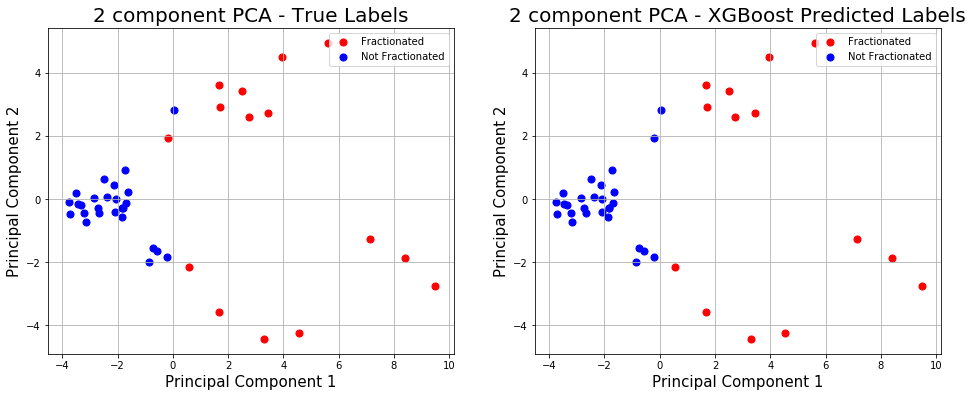

In [26]:
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1) 
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 component PCA - True Labels', fontsize = 20)
labels = [1, 0]
colors = ['r', 'b']
for label, color in zip(labels,colors):
    idx_to_keep = (final_df['Label'].values == label)
    ax1.scatter(final_df.loc[idx_to_keep, 'principal component 1']
               , final_df.loc[idx_to_keep, 'principal component 2']
               , c = color
               , s = 50)
ax1.legend(['Fractionated', 'Not Fractionated'])
ax1.grid()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
ax2.set_title('2 component PCA - XGBoost Predicted Labels', fontsize = 20)
predictions = [1, 0]
colors = ['r', 'b']
for prediction, color in zip(predictions,colors):
    idx_to_keep = (final_df['XGBoost Predictions'].values == prediction)
    ax2.scatter(final_df.loc[idx_to_keep, 'principal component 1']
               , final_df.loc[idx_to_keep, 'principal component 2']
               , c = color
               , s = 50)
ax2.legend(['Fractionated', 'Not Fractionated'])
ax2.grid()

In [30]:
pca_patient = final_df[final_df['Patient']=='3']
pca_patient.head()

,principal component 1,principal component 2,index,Label,Patient,Type,Coupling Interval,SVM Predictions,Naive Bayes Predictions,KNN Predictions,GP Predictions,XGBoost Predictions
0,-2.722992,-0.280348,28,0.0,3,af,400,0.0,0.0,0.0,0.0,0.0
1,-3.208026,-0.436354,29,0.0,3,af,390,0.0,0.0,0.0,0.0,0.0
2,-3.762095,-0.109795,30,0.0,3,af,380,0.0,0.0,0.0,0.0,0.0
3,-3.733450,-0.480657,31,0.0,3,af,370,0.0,0.0,0.0,0.0,0.0
4,-3.162584,-0.714888,32,0.0,3,af,360,0.0,0.0,0.0,0.0,0.0


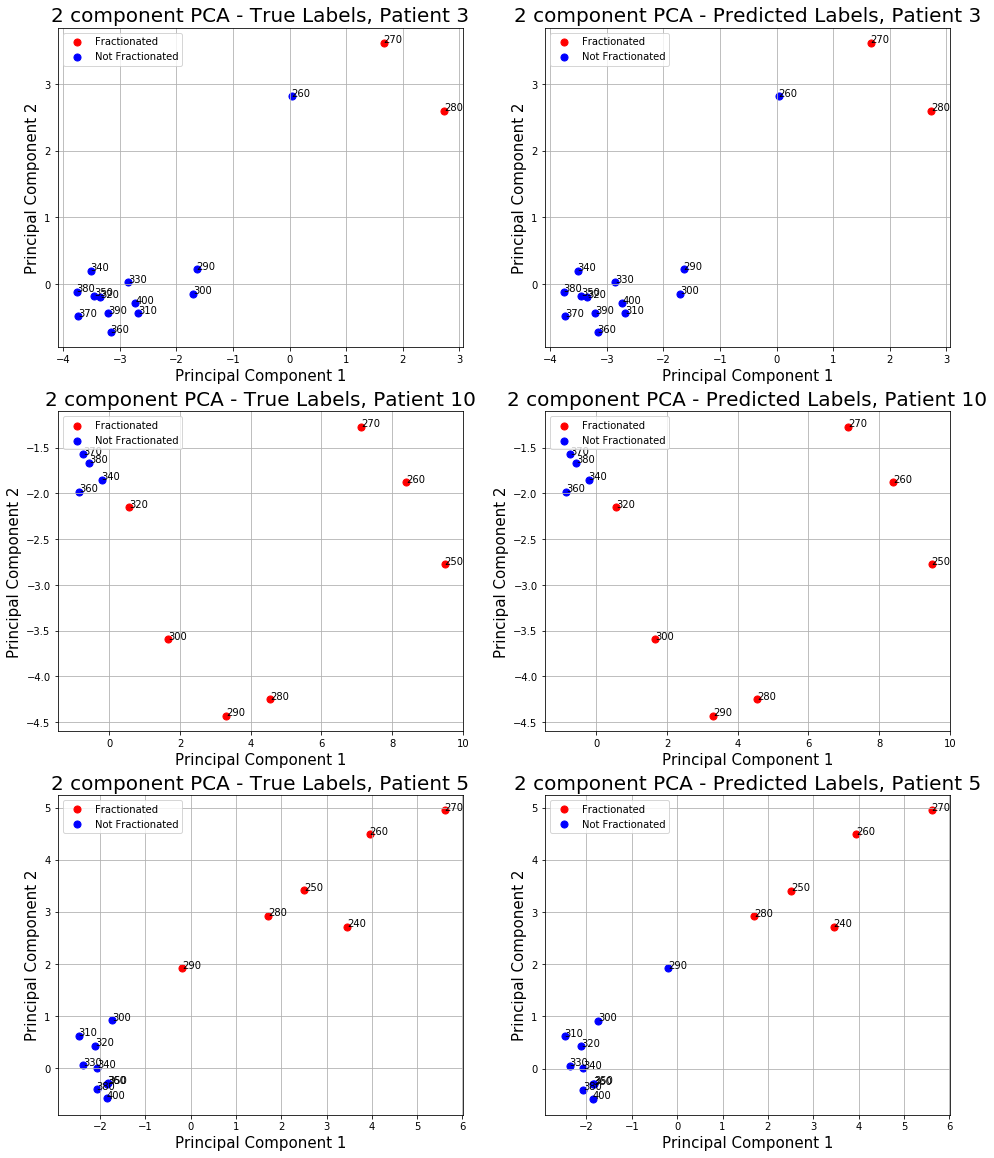

In [43]:
fig, axes = plt.subplots(nrows=len(test_patients), ncols=2, figsize = (16,20))

labels = [1, 0]
colors = ['r', 'b']

for i, patient in enumerate(test_patients):
    axes[i][0].set_xlabel('Principal Component 1', fontsize = 15)
    axes[i][0].set_ylabel('Principal Component 2', fontsize = 15)
    axes[i][0].set_title('2 component PCA - True Labels, Patient ' + patient, fontsize = 20)
    axes[i][1].set_xlabel('Principal Component 1', fontsize = 15)
    axes[i][1].set_ylabel('Principal Component 2', fontsize = 15)
    axes[i][1].set_title('2 component PCA - Predicted Labels, Patient ' + patient, fontsize = 20)
    pca_patient = final_df[final_df['Patient']==patient]
    for label, color in zip(labels,colors):
        idx_to_keep = (pca_patient['Label'].values == label)
        axes[i][0].scatter(pca_patient.loc[idx_to_keep, 'principal component 1']
                   , pca_patient.loc[idx_to_keep, 'principal component 2']
                   , c = color
                   , s = 50)
        
        idx_to_keep = (pca_patient['XGBoost Predictions'].values == label)
        axes[i][1].scatter(pca_patient.loc[idx_to_keep, 'principal component 1']
               , pca_patient.loc[idx_to_keep, 'principal component 2']
               , c = color
               , s = 50)
        
        for _,row in pca_patient[idx_to_keep].iterrows():
            axes[i][0].annotate(row['Coupling Interval'], 
                                (row['principal component 1'], row['principal component 2']))
            
            axes[i][1].annotate(row['Coupling Interval'], 
                                (row['principal component 1'], row['principal component 2']))
        
    axes[i][0].legend(['Fractionated', 'Not Fractionated'])
    axes[i][0].grid()
    axes[i][1].legend(['Fractionated', 'Not Fractionated'])
    axes[i][1].grid()

In [46]:
y_training == 0

0       True
1       True
2       True
3       True
4       True
5       True
6       True
7       True
8      False
9      False
10     False
11     False
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21      True
22      True
23      True
24      True
25      True
26      True
27      True
28      True
29      True
       ...  
76      True
77     False
78     False
79      True
80      True
81      True
82      True
83      True
84      True
85      True
86      True
87     False
88     False
89      True
90      True
91     False
92     False
93     False
94     False
95      True
96      True
97      True
98      True
99      True
100     True
101     True
102     True
103     True
104    False
105    False
Name: Label, Length: 91, dtype: bool

In [50]:
sf = y_training[y_training == 0].shape[0]/y_training[y_training == 1].shape[0]
print(sf)

4.055555555555555


In [57]:
xgb1 = xgboost.XGBClassifier()
xgb2 = xgboost.XGBClassifier(scale_pos_weight=sf)

print('Cross validation scores on combined data:')
print(cross_val_score(xgb1, X_training.values, y_training.values, cv=3))
print(cross_val_score(xgb2, X_training.values, y_training.values, cv=3))

Cross validation scores on combined data:
[0.87096774 0.8        0.93333333]
[0.90322581 0.8        0.86666667]
